This jupyter notebook explore clustering on service_code_description. This includes k-medoids clustering and meta clustering, where we cluster the clusters obtained to see if we can find some meaning in the groupings. 

## Requirements

In [32]:
pip uninstall -y numpy scikit-learn scikit-learn-extra

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
You can safely remove it manually.
You can safely remove it manually.
Found existing installation: scikit-learn 1.3.2
Uninstalling scikit-learn-1.3.2:
  Successfully uninstalled scikit-learn-1.3.2
You can safely remove it manually.
You can safely remove it manually.
Found existing installation: scikit-learn-extra 0.3.0
Uninstalling scikit-learn-extra-0.3.0:
  Successfully uninstalled scikit-learn-extra-0.3.0
You can safely remove it manually.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
!pip  install --no-user\
    "numpy<2.0" \
    "scikit-learn<1.4" \
    scikit-learn-extra \
    gower \
    umap-learn


  Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached scikit_learn-1.3.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
  Using cached scikit_learn_extra-0.3.0-cp312-cp312-linux_x86_64.whl
Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.0 MB)
Using cached scikit_learn-1.3.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (10.8 MB)
   ━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━ 1/3 [scikit-learn]

## k-medoids Clustering

In [26]:
import sys
import numpy.core.numeric as core_numeric
import types

# Create a dummy module named "numpy._core.numeric"
shim = types.ModuleType("numpy._core.numeric")
shim.__dict__.update(core_numeric.__dict__)
sys.modules["numpy._core.numeric"] = shim

import pickle
with open('processed_data_v1.pkl', 'rb') as f:
    df = pickle.load(f)

In [27]:
df.head()

,incident_count,date_created,hour_created,max_final_priority,inc_resourced,scrs_crime_inc,multi_member_ward,datazone,dzone_code,service_code_description
0,2,2023-08-11,7,PROMPT,False,False,Dennistoun,Carntyne West and Haghill - 03,S01010244,ROAD TRAFFIC COLLISION
1,2,2023-02-16,20,PROMPT,True,False,Lochee,Charleston - 04,S01007848,ASSIST MEMBER OF THE PUBLIC
2,2,2024-09-05,0,STANDARD,False,True,Leith Walk,South Leith - 05,S01008796,THEFT
3,2,2024-09-02,14,PROMPT,True,False,Almond,"Ratho, Ingliston and Gogar - 01",S01008993,EXTERNAL AGENCY REQUEST
4,2,2022-04-12,19,PROMPT,True,False,Paisley North West,Paisley North - 06,S01012158,EXTERNAL AGENCY REQUEST


### Preprocessing

In [28]:
# drop tables that are not required
df = df.drop(columns=['incident_count', 'datazone', 'multi_member_ward'])
df.columns

Index(['date_created', 'hour_created', 'max_final_priority', 'inc_resourced',
       'scrs_crime_inc', 'dzone_code', 'service_code_description'],
      dtype='object')

In [29]:
# pull useful calendar parts; drop raw timestamp afterwards
df['weekday'] = df['date_created'].dt.day_of_week
df['month'] = df['date_created'].dt.month

# OPTIONAL: keep year safely  ➜ treat as categorical proportions
df["year"] = df["date_created"].dt.year.astype("category")

df = df.drop(columns=["date_created"])# raw timestamp no longer needed

In [30]:
# DTYPE COERCION  (ensures Gower treats cols correctly)
group_col = "service_code_description"

num_cols  = ["hour_created", "inc_resourced", "scrs_crime_inc"]   # numeric / binary
cat_cols  = ["max_final_priority", "service_code_description",
             "weekday", "month", "year"]                          # categoricals

for c in cat_cols + [group_col]:
    df[c] = df[c].astype("category")
df[num_cols] = df[num_cols].astype(float)

In [31]:
# Aggregation
agg = (
    df.groupby("service_code_description", sort=False)
      .agg(
          # ------ volume & basic proportions ------
          n_incidents         = ("hour_created", "size"),
          pct_resourced       = ("inc_resourced",  "mean"),
          pct_scrs_crime      = ("scrs_crime_inc", "mean"),

          # ------ time of day ------
          avg_hour_created    = ("hour_created", "mean"),

          # ------ priority breakdown ------
          mode_priority       = ("max_final_priority",
                                 lambda x: x.mode().iloc[0]),
          pct_standard        = ("max_final_priority",
                                 lambda x: (x == "STANDARD").mean()),
          pct_prompt          = ("max_final_priority",
                                 lambda x: (x == "PROMPT").mean()),
          pct_immediate       = ("max_final_priority",
                                 lambda x: (x == "IMMEDIATE").mean()),

          # ------ most common categorical values ------
          common_dzone        = ("dzone_code", lambda x: x.mode().iloc[0]),
          common_weekday      = ("weekday",    lambda x: x.mode().iloc[0]),
          common_month        = ("month",      lambda x: x.mode().iloc[0]),
          common_year         = ("year",       lambda x: x.mode().iloc[0]),
      )
      .reset_index()      # keep service_code_description as a column
)

print(f"{agg.shape[0]} service types × {agg.shape[1]} columns in the aggregated table")


/tmp/dcs-tmp.u2164966/ipykernel_88024/2416751098.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("service_code_description", sort=False)


90 service types × 13 columns in the aggregated table


In [95]:
import pandas as pd, numpy as np
import gower                                   # pip install gower
from sklearn_extra.cluster import KMedoids     # pip install scikit-learn-extra
from sklearn.metrics import silhouette_score
import umap, matplotlib.pyplot as plt
import seaborn as sns

In [96]:
# Distance calculation

# keep only feature columns (everything except the identifier)
X = agg.drop(columns=["service_code_description"])

# tell gower which columns are categorical (dtype == 'category')
cat_mask = X.dtypes == "category"

# pair-wise distance (∈ [0, 1])
D = gower.gower_matrix(X, cat_features=cat_mask)

In [97]:
# Pick best k with silhouette
best_k, best_score, best_model = None, -1, None
for k in range(2, min(15, len(agg))):
    km = KMedoids(
        n_clusters=k,
        metric="precomputed",
        init="k-medoids++",
        method="pam",
        random_state=42
    ).fit(D)

    sil = silhouette_score(D, km.labels_, metric="precomputed")
    if sil > best_score:
        best_k, best_score, best_model = k, sil, km

agg["cluster"] = best_model.labels_
print(f"✔  k={best_k}  (silhouette={best_score:0.3f})")

✔  k=12  (silhouette=0.218)


/dcs/large/u2164966/MSc_Dissertation/myenv/lib64/python3.12/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/dcs/large/u2164966/MSc_Dissertation/myenv/lib64/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


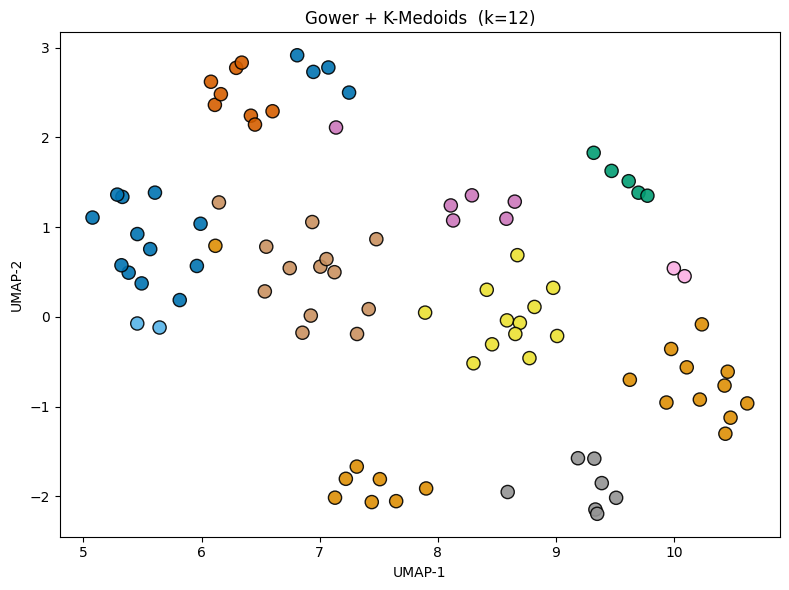

In [98]:
# 2-D UMAP projection for plotting
from matplotlib.colors import ListedColormap
emb = umap.UMAP(
    metric="precomputed",
    random_state=42
).fit_transform(D)

palette = sns.color_palette("colorblind", n_colors=agg["cluster"].nunique())
cmap     = ListedColormap(palette)

fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(
    emb[:, 0], emb[:, 1],
    c=agg["cluster"],
    cmap=cmap,
    s=90, edgecolor="k", alpha=0.9
)
ax.set(
    title=f"Gower + K-Medoids  (k={best_k})",
    xlabel="UMAP-1", ylabel="UMAP-2"
)
plt.tight_layout()
plt.show()

In [19]:
import pandas as pd

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(agg[['service_code_description', 'cluster']])

          service_code_description  cluster
0           ROAD TRAFFIC COLLISION        4
1      ASSIST MEMBER OF THE PUBLIC        6
2                            THEFT        5
3          EXTERNAL AGENCY REQUEST        6
4             ROAD TRAFFIC OFFENCE       11
5                          ROBBERY        3
6                   SEXUAL OFFENCE       11
7                     SUDDEN DEATH       10
8                  SUSPECT PERSONS       11
9              SUSPICIOUS INCIDENT        7
10                   TASK INCIDENT       10
11              UTILITIES INCIDENT        6
12                   VEHICLE CRIME        5
13                  WILDLIFE CRIME        6
14              ABANDONED VEHICLES        7
15       ABANDONED/SILENT 999 CALL        9
16  ABDUCTION/EXTORTION/SEXTORTION        3
17                         ANIMALS        6
18                         ASSAULT        3
19                    AUDIBLE ONLY        9
20      BAIL/CURFEW/ADDRESS CHECKS        6
21                CHILD PROTECTI

In [99]:
# Clusters and which service codes are present in them
for c, group in agg.groupby('cluster'):
    print(f"Cluster {c}:")
    for s in group['service_code_description']:
        print(f"  - {s}")
    print()


Cluster 0:
  - VEHICLE PURSUIT
  - PERSONAL ATTACK ALARM
  - TEST INCIDENT
  - AIRPORT FULL EMERGENCY

Cluster 1:
  - ABANDONED/SILENT 999 CALL
  - AUDIBLE ONLY
  - FIRES
  - FORENSIC EXAMINATION
  - NOISE
  - PUBLIC NUISANCE
  - INSECURE PREMISES

Cluster 2:
  - THEFT
  - VEHICLE CRIME
  - DAMAGE
  - FRAUD INCIDENT
  - NEIGHBOUR DISPUTE

Cluster 3:
  - WATERBORNE INCIDENT
  - AIRPORT GROUND INCIDENT
  - RAIL INCIDENT
  - POLICE INSTALLATION
  - CHEMICAL SPILLAGE
  - EXPLOSION
  - CRIME IN PROGRESS
  - POLICE EMERGENCY

Cluster 4:
  - ROBBERY
  - ABDUCTION/EXTORTION/SEXTORTION
  - ASSAULT
  - DISTURBANCE
  - HOUSEBREAKING
  - OTHER CRIME

Cluster 5:
  - SUSPICIOUS INCIDENT
  - ABANDONED VEHICLES
  - DRUGS/SUBSTANCE MISUSE
  - ERROR
  - EXTERNAL FORCE REQUEST
  - LOST/FOUND PROPERTY
  - POLICE INFORMATION
  - WEATHER
  - INTERNAL FORCE REQUEST
  - DRINKING IN PUBLIC
  - ACCIDENTS
  - STANDING COMPLAINT
  - ESCAPEE/AWOL

Cluster 6:
  - ROAD TRAFFIC COLLISION
  - COMMUNICATIONS

Cluster 7

## Clustering of Clusters

In [101]:
# 1. Hierarchical “cluster-of-clusters” on the PAM medoids
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from scipy.spatial.distance import squareform
from sklearn.metrics import silhouette_score
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# a) distance matrix among the k medoids ------------------------
medoid_idx  = best_model.medoid_indices_               # len == k
D_medoid    = D[np.ix_(medoid_idx, medoid_idx)]        # k × k

# b) hierarchy --------------------------------------------------
Z = linkage(squareform(D_medoid, checks=False), method="average")

# c) pick meta_k by silhouette on the k×k matrix ---------------
sil_scores = {}
for kmeta in range(2, min(6, len(medoid_idx))):        # try 2…5 (or up to k-1)
    lab = fcluster(Z, kmeta, criterion="maxclust")
    sil_scores[kmeta] = silhouette_score(
        D_medoid, lab, metric="precomputed"
    )

meta_k       = max(sil_scores, key=sil_scores.get)
meta_labels  = fcluster(Z, meta_k, criterion="maxclust")

print(f"✔  meta-k = {meta_k}   (silhouette={sil_scores[meta_k]:0.3f})")

# d) map from original PAM-cluster ⇒ meta-cluster --------------
cluster_to_meta = {
    c: meta_labels[i] for i, c in enumerate(range(len(medoid_idx)))
}
agg["meta_cluster"] = agg["cluster"].map(cluster_to_meta)


✔  meta-k = 2   (silhouette=0.218)


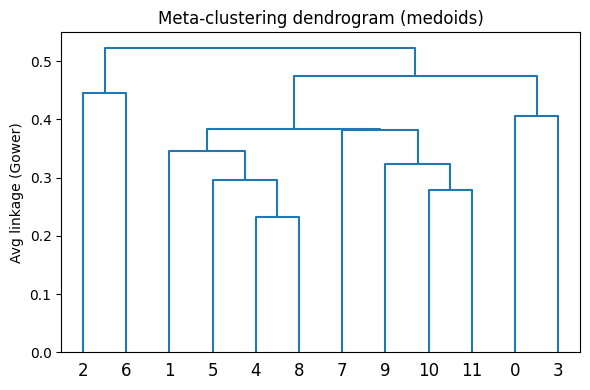

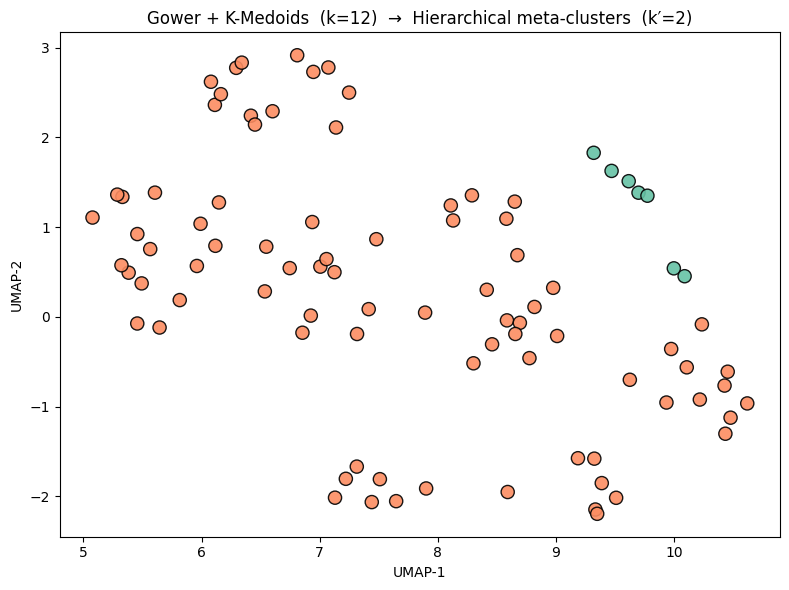

In [103]:
# –– dendrogram of the medoids ––
plt.figure(figsize=(6, 4))
dendrogram(
    Z,
    labels=[f"{c}" for c in range(len(medoid_idx))],
    color_threshold=0        # one colour per leaf
)
plt.title("Meta-clustering dendrogram (medoids)")
plt.ylabel("Avg linkage (Gower)")
plt.tight_layout()
plt.show()

# –– UMAP coloured by meta-clusters ––
palette_meta = sns.color_palette("Set2", n_colors=agg["meta_cluster"].nunique())
cmap_meta    = ListedColormap(palette_meta)

fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(
    emb[:, 0], emb[:, 1],
    c=agg["meta_cluster"], cmap=cmap_meta,
    s=90, edgecolor="k", alpha=0.9
)
ax.set(
    title=(f"Gower + K-Medoids  (k={best_k})  →  "
           f"Hierarchical meta-clusters  (k′={meta_k})"),
    xlabel="UMAP-1", ylabel="UMAP-2"
)
plt.tight_layout()
plt.show()

In [105]:
label_col = "meta_cluster"        # ← or "cluster", "double_cluster", …

for c, grp in agg.groupby(label_col, sort=True):
    print(f"{label_col.replace('_', ' ').title()} {c}:")
    for s in grp["service_code_description"].unique():   # .unique() avoids repeats
        print(f"  - {s}")
    print()  # blank line between clusters

Meta Cluster 1:
  - ROAD TRAFFIC COLLISION
  - THEFT
  - VEHICLE CRIME
  - COMMUNICATIONS
  - DAMAGE
  - FRAUD INCIDENT
  - NEIGHBOUR DISPUTE

Meta Cluster 2:
  - ASSIST MEMBER OF THE PUBLIC
  - EXTERNAL AGENCY REQUEST
  - ROAD TRAFFIC OFFENCE
  - ROBBERY
  - SEXUAL OFFENCE
  - SUDDEN DEATH
  - SUSPECT PERSONS
  - SUSPICIOUS INCIDENT
  - TASK INCIDENT
  - UTILITIES INCIDENT
  - WILDLIFE CRIME
  - ABANDONED VEHICLES
  - ABANDONED/SILENT 999 CALL
  - ABDUCTION/EXTORTION/SEXTORTION
  - ANIMALS
  - ASSAULT
  - AUDIBLE ONLY
  - BAIL/CURFEW/ADDRESS CHECKS
  - CHILD PROTECTION
  - CONCERN FOR PERSON
  - DISTURBANCE
  - DOMESTIC BAIL CHECK
  - DOMESTIC INCIDENT
  - DRUGS/SUBSTANCE MISUSE
  - DUPLICATE INCIDENT
  - ERROR
  - EXTERNAL FORCE REQUEST
  - FALSE CALL
  - FIREARMS INCIDENT
  - FIRES
  - FORENSIC EXAMINATION
  - HATE CRIME
  - HOUSEBREAKING
  - INTRUDER
  - LOST/FOUND PROPERTY
  - MESSAGE FOR DELIVERY
  - MISSING PERSON/ABSCONDER
  - NOISE
  - PLANNED SHOOT / PEST CONTROL
  - POLICE G

## Hierarchical Clustering

✔  k=3  via hierarchical clustering  (silhouette=0.285)


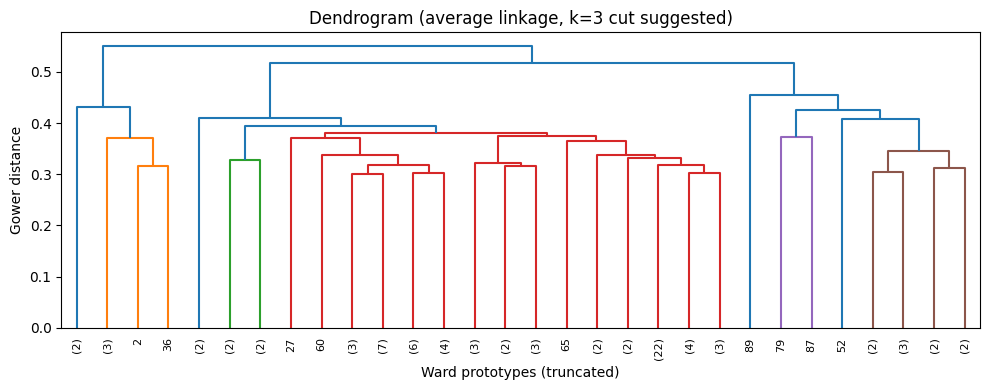

In [23]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram
import scipy.spatial.distance as ssd

# (a) pick k by silhouette, exactly as before
best_k, best_score, best_labels = None, -1, None
for k in range(2, min(15, len(agg))):
    hac = AgglomerativeClustering(
              n_clusters=k,
              metric="precomputed",         # tells sklearn we pass a distance matrix
              linkage="average"             # Ward needs Euclidean, so use average
          ).fit(D)
    sil = silhouette_score(D, hac.labels_, metric="precomputed")
    if sil > best_score:
        best_k, best_score, best_labels = k, sil, hac.labels_

agg["cluster"] = best_labels
print(f"✔  k={best_k}  via hierarchical clustering  (silhouette={best_score:0.3f})")

# (b) quick dendrogram for interpretability  (optional visual)
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram

# scipy linkage needs a condensed 1-D vector
condensed = ssd.squareform(D, checks=False)
Z = linkage(condensed, method="average")

plt.figure(figsize=(10, 4))
dendrogram(
    Z,
    truncate_mode="lastp",   # show top‐level structure only
    p=30,                    # show last 30 merged clusters
    leaf_rotation=90,
    leaf_font_size=8,
    color_threshold=None
)
plt.title(f"Dendrogram (average linkage, k={best_k} cut suggested)")
plt.xlabel("Ward prototypes (truncated)")
plt.ylabel("Gower distance")
plt.tight_layout()
plt.show()

In [25]:
for c, group in agg.groupby('cluster'):
    print(f"Cluster {c}:")
    for s in group['service_code_description']:
        print(f"  - {s}")
    print()


Cluster 0:
  - DISTURBANCE
  - VEHICLE PURSUIT
  - WATERBORNE INCIDENT
  - PERSONAL ATTACK ALARM
  - AIRPORT GROUND INCIDENT
  - RAIL INCIDENT
  - POLICE INSTALLATION
  - CHEMICAL SPILLAGE
  - TEST INCIDENT
  - EXPLOSION
  - AIRPORT FULL EMERGENCY
  - CRIME IN PROGRESS
  - POLICE EMERGENCY

Cluster 1:
  - ROAD TRAFFIC COLLISION
  - THEFT
  - VEHICLE CRIME
  - COMMUNICATIONS
  - DAMAGE
  - FRAUD INCIDENT
  - NEIGHBOUR DISPUTE

Cluster 2:
  - ASSIST MEMBER OF THE PUBLIC
  - EXTERNAL AGENCY REQUEST
  - ROAD TRAFFIC OFFENCE
  - ROBBERY
  - SEXUAL OFFENCE
  - SUDDEN DEATH
  - SUSPECT PERSONS
  - SUSPICIOUS INCIDENT
  - TASK INCIDENT
  - UTILITIES INCIDENT
  - WILDLIFE CRIME
  - ABANDONED VEHICLES
  - ABANDONED/SILENT 999 CALL
  - ABDUCTION/EXTORTION/SEXTORTION
  - ANIMALS
  - ASSAULT
  - AUDIBLE ONLY
  - BAIL/CURFEW/ADDRESS CHECKS
  - CHILD PROTECTION
  - CONCERN FOR PERSON
  - DOMESTIC BAIL CHECK
  - DOMESTIC INCIDENT
  - DRUGS/SUBSTANCE MISUSE
  - DUPLICATE INCIDENT
  - ERROR
  - EXTERNAL